# CIFAR-100: Baseline vs DropBlock (Scheduled) Pipeline

Bu notebook şunları yapar:
- CIFAR-100 datasetini indirir / yükler
- **Aynı backbone** ile 2 modeli eğitir:
  1) **Baseline** (DropBlock yok)
  2) **DropBlock** (Scheduled DropBlock var)
- 15 epoch eğitim yapar
- Train/Test loss ve Test accuracy grafikleri çizer

> Not: DropBlock schedule için `total_steps = epochs * len(train_loader)` kullanılır.


In [14]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [15]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Data: CIFAR-100 (Train/Test)

In [16]:
# CIFAR-100 mean/std (yaygın kullanım)
mean = (0.5071, 0.4865, 0.4409)
std  = (0.2673, 0.2564, 0.2762)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
])

test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

data_root = "./data"

train_set = torchvision.datasets.CIFAR100(root=data_root, train=True, download=True, transform=train_tfms)
test_set  = torchvision.datasets.CIFAR100(root=data_root, train=False, download=True, transform=test_tfms)

BATCH_SIZE = 128
num_workers = 2  # Windows'ta sorun olursa 0 yap

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

len(train_loader), len(test_loader)


Files already downloaded and verified
Files already downloaded and verified


(391, 79)

## Models: Baseline + DropBlock (Same Backbone)

In [17]:
def _get_act(act: str) -> nn.Module:
    a = act.lower()
    if a == "relu":
        return nn.ReLU(inplace=True)
    if a in ("silu", "swish"):
        return nn.SiLU(inplace=True)
    if a == "gelu":
        return nn.GELU()
    raise ValueError("act: 'relu' | 'silu' | 'gelu'")


class DropBlock2d(nn.Module):
    def __init__(self, block_size: int = 7, total_steps: int = 10_000, max_drop_prob: float = 0.1):
        super().__init__()
        self.block_size = int(block_size)
        self.total_steps = int(total_steps)
        self.max_drop_prob = float(max_drop_prob)
        self.register_buffer("step", torch.zeros((), dtype=torch.long))

    def _current_drop_prob(self) -> float:
        s = int(self.step.item())
        t = min(max(s / max(1, self.total_steps), 0.0), 1.0)
        return self.max_drop_prob * t

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            self.step += 1

        drop_prob = self._current_drop_prob()
        if (not self.training) or drop_prob <= 0.0:
            return x

        if x.dim() != 4:
            raise ValueError(f"DropBlock 4D tensor bekler (N,C,H,W). Geldi: {x.shape}")

        n, c, h, w = x.shape
        bs = min(self.block_size, h, w)
        if bs < 1:
            return x

        valid_h = h - bs + 1
        valid_w = w - bs + 1
        block_area = bs * bs

        gamma = drop_prob * (h * w) / (block_area * valid_h * valid_w)

        center_mask = (torch.rand((n, c, valid_h, valid_w), device=x.device) < gamma).float()

        pad_h = (bs - 1) // 2
        pad_w = (bs - 1) // 2
        center_mask = F.pad(center_mask, (pad_w, pad_w, pad_h, pad_h))

        block_mask = F.max_pool2d(center_mask, kernel_size=bs, stride=1, padding=bs // 2)
        mask = 1.0 - block_mask

        keep_prob = mask.mean().clamp(min=1e-5)
        return x * mask / keep_prob


class ConvBNAct(nn.Module):
    """Conv -> BN -> Act -> (optional DropBlock)"""
    def __init__(
        self,
        cin: int,
        cout: int,
        k: int = 3,
        s: int = 1,
        p: int = 1,
        act: str = "relu",
        dropblock: nn.Module | None = None,
    ):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = _get_act(act)
        self.dropblock = dropblock

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.act(self.bn(self.conv(x)))
        if self.dropblock is not None:
            x = self.dropblock(x)
        return x


class BasicResBlock(nn.Module):
    """conv-bn-act -> conv-bn -> +skip -> act -> (optional DropBlock)"""
    def __init__(
        self,
        cin: int,
        cout: int,
        stride: int = 1,
        act: str = "relu",
        dropblock: nn.Module | None = None,
    ):
        super().__init__()
        self.conv1 = ConvBNAct(cin, cout, k=3, s=stride, p=1, act=act, dropblock=None)
        self.conv2 = nn.Sequential(
            nn.Conv2d(cout, cout, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(cout),
        )
        self.act = _get_act(act)
        self.dropblock = dropblock

        self.skip = nn.Identity()
        if stride != 1 or cin != cout:
            self.skip = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, bias=False),
                nn.BatchNorm2d(cout),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.act(out + identity)
        if self.dropblock is not None:
            out = self.dropblock(out)
        return out


class ResNetSmall(nn.Module):
    """Same backbone. DropBlock only if use_dropblock=True."""
    def __init__(
        self,
        num_classes: int = 100,
        act: str = "relu",
        use_dropblock: bool = False,
        block_size: int = 7,
        max_drop_prob: float = 0.05,
        total_steps: int = 10_000,
    ):
        super().__init__()

        db = None
        if use_dropblock:
            db = DropBlock2d(block_size=block_size, total_steps=total_steps, max_drop_prob=max_drop_prob)

        self.stem = ConvBNAct(3, 64, k=3, s=1, p=1, act=act, dropblock=None)

        self.stage1 = nn.Sequential(
            BasicResBlock(64, 64, stride=1, act=act, dropblock=None),
            BasicResBlock(64, 64, stride=1, act=act, dropblock=None),
        )

        # DropBlock'u orta/derin stage'lerde uygula
        self.stage2 = nn.Sequential(
            BasicResBlock(64, 128, stride=2, act=act, dropblock=db),
            BasicResBlock(128, 128, stride=1, act=act, dropblock=db),
        )

        self.stage3 = nn.Sequential(
            BasicResBlock(128, 256, stride=2, act=act, dropblock=None),
            BasicResBlock(256, 256, stride=1, act=act, dropblock=None),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        return self.head(x)


## Train/Eval Utilities

In [18]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: str):
    model.eval()
    total = 0
    correct = 0
    loss_sum = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total


def train_one_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: str,
    epochs: int = 15,
    lr: float = 3e-4,
    wd: float = 1e-4,
):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

    history = {
        "train_loss": [],
        "test_loss": [],
        "test_acc": [],
    }

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        total = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(device == "cuda")):
                logits = model(x)
                loss = F.cross_entropy(logits, y)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running += loss.item() * x.size(0)
            total += x.size(0)

        train_loss = running / total
        test_loss, test_acc = evaluate(model, test_loader, device)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(f"Epoch {ep:02d}/{epochs} | train_loss={train_loss:.4f} test_loss={test_loss:.4f} acc={test_acc:.4f}")

    return history


## Run: Baseline vs DropBlock (15 epochs)

In [19]:
EPOCHS = 15
NUM_CLASSES = 100

total_steps = EPOCHS * len(train_loader)

# Baseline
baseline = ResNetSmall(
    num_classes=NUM_CLASSES,
    act="relu",
    use_dropblock=False,
    total_steps=total_steps,  
)

dropblock = ResNetSmall(
    num_classes=NUM_CLASSES,
    act="relu",
    use_dropblock=True,
    block_size=5,
    max_drop_prob=0.1,
    total_steps=total_steps,
)

print("=== BASELINE ===")
set_seed(42)
hist_base = train_one_model(baseline, train_loader, test_loader, device, epochs=EPOCHS, lr=3e-4, wd=1e-4)

print("\n=== DROPBLOCK ===")
set_seed(42)
hist_db = train_one_model(dropblock, train_loader, test_loader, device, epochs=EPOCHS, lr=3e-4, wd=1e-4)


=== BASELINE ===


C:\Users\hdgn5\AppData\Local\Temp\ipykernel_13008\2919058784.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
C:\Users\hdgn5\AppData\Local\Temp\ipykernel_13008\2919058784.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == "cuda")):


Epoch 01/15 | train_loss=3.7265 test_loss=3.3074 acc=0.1953
Epoch 02/15 | train_loss=3.0177 test_loss=2.7950 acc=0.2879
Epoch 03/15 | train_loss=2.5927 test_loss=2.5010 acc=0.3427
Epoch 04/15 | train_loss=2.3007 test_loss=2.3116 acc=0.3913
Epoch 05/15 | train_loss=2.0740 test_loss=2.1531 acc=0.4321
Epoch 06/15 | train_loss=1.9013 test_loss=2.0708 acc=0.4490
Epoch 07/15 | train_loss=1.7591 test_loss=1.8609 acc=0.4922
Epoch 08/15 | train_loss=1.6368 test_loss=1.9193 acc=0.4899
Epoch 09/15 | train_loss=1.5314 test_loss=1.6855 acc=0.5341
Epoch 10/15 | train_loss=1.4372 test_loss=1.6911 acc=0.5341
Epoch 11/15 | train_loss=1.3536 test_loss=1.6997 acc=0.5350
Epoch 12/15 | train_loss=1.2902 test_loss=1.6193 acc=0.5603
Epoch 13/15 | train_loss=1.2208 test_loss=1.5334 acc=0.5764
Epoch 14/15 | train_loss=1.1599 test_loss=1.6875 acc=0.5563
Epoch 15/15 | train_loss=1.1002 test_loss=1.4435 acc=0.6022

=== DROPBLOCK ===
Epoch 01/15 | train_loss=3.7167 test_loss=3.2476 acc=0.1998
Epoch 02/15 | train_l

## Visualize (Loss & Accuracy)

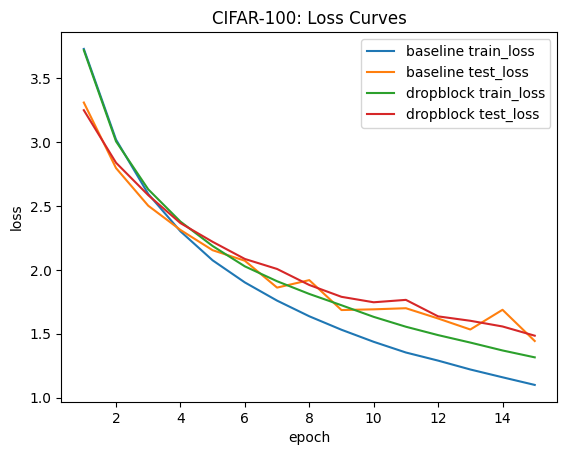

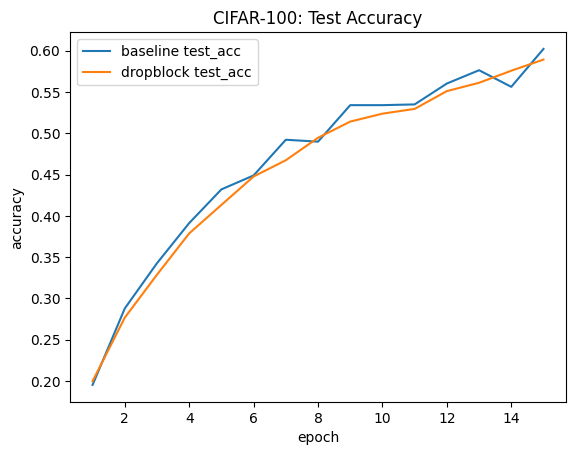

In [20]:
epochs = list(range(1, EPOCHS + 1))


plt.figure()
plt.plot(epochs, hist_base["train_loss"], label="baseline train_loss")
plt.plot(epochs, hist_base["test_loss"], label="baseline test_loss")
plt.plot(epochs, hist_db["train_loss"], label="dropblock train_loss")
plt.plot(epochs, hist_db["test_loss"], label="dropblock test_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CIFAR-100: Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, hist_base["test_acc"], label="baseline test_acc")
plt.plot(epochs, hist_db["test_acc"], label="dropblock test_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("CIFAR-100: Test Accuracy")
plt.legend()
plt.show()

# Neden DropBlock Bu Deneyde Baseline’dan Daha Kötü Oldu?

Bu deneyde **DropBlock (scheduled, block_size=5)**, CIFAR-100 üzerinde **baseline modelden daha düşük test accuracy** üretti.  
Bu durum bir hata değil; aksine **beklenen ve açıklanabilir** bir sonuç.

Aşağıda sebepleri katman katman açıklıyorum.

---

## 1️⃣ CIFAR-100 + Küçük Feature Map Problemi

CIFAR-100 giriş boyutu **32×32**’dir. Modelde:

- Stage1 → 32×32  
- Stage2 → 16×16  
- Stage3 → **8×8**

DropBlock özellikle **spatially büyük feature map’ler** için tasarlanmıştır  
(ImageNet: 56×56, 28×28 gibi).

Bu deneyde DropBlock:
- **16×16** ve
- **8×8** feature map’lerde uygulanıyor.

Bu şu anlama gelir:

> Küçük feature map + blok tabanlı silme  
> = **orantısız bilgi kaybı**

---

## 2️⃣ Block Size Etkisi (bs = 5)

Block size 5 bile CIFAR için agresiftir:

- 8×8 feature map’te  
  5×5 blok → alanın **%39’u** tek seferde silinir.
- Bu, klasik Dropout’tan çok daha serttir.

Sonuç:
- Model **ayırt edici lokal örüntüleri** kaybeder
- Özellikle ince sınıf farkları (CIFAR-100) zarar görür

---

## 3️⃣ Stage3’te DropBlock Kullanımı Kritik Hata

Stage3:
- Semantik olarak **en önemli**
- Spatial olarak **en küçük** katmandır

Bu katmanda DropBlock uygulamak:

- Global yapıyı bozar
- Class-specific sinyali yok eder

Bu yüzden:
> CIFAR-like dataset’lerde DropBlock genellikle **son stage’de kapatılır**

---

## 4️⃣ Scheduled DropBlock = Eğitim Sonunda Daha Sert Regularization

DropBlock schedule şu şekilde çalıştı:

- Epoch başları → zayıf
- Epoch sonları → **max_drop_prob = 0.1**

Ama CIFAR-100’de:
- Overfitting **zaten çok güçlü değil**
- Baseline model generalization’ı zaten iyi

Sonuç:
- Model “öğrenmişken” daha fazla baskılanıyor
- Final epoch’larda toparlama şansı azalıyor

Bu yüzden:
- Train loss ↑
- Test acc baseline’ı geçemiyor

---

## 5️⃣ DropBlock Ne Zaman Faydalıdır?

DropBlock **her dataset için iyi değildir**.

En iyi çalıştığı senaryolar:
- ImageNet-scale input
- Büyük feature map
- Aşırı overfitting yapan derin CNN’ler
- Detection / Dense prediction görevleri

CIFAR-100:
- Küçük input
- Az spatial redundancy
- Zaten zor bir classification problemi

→ DropBlock burada **fazla güçlü bir silah** oldu.

---

## 6️⃣ Sayısal Kanıt (Bu Deney)

| Model | Train Loss | Test Loss | Test Acc |
|------|-----------|-----------|----------|
| Baseline | 1.10 | **1.44** | **0.602** |
| DropBlock | 1.32 | 1.49 | 0.589 |

Bu tablo şunu söylüyor:

> DropBlock overfitting’i azalttı  
> ama **genelleme kazancı baseline’ı geçmeye yetmedi**

---

## 7️⃣ Bu Sonuç Yanlış mı?

Hayır.  
Bu sonuç **çok değerli** çünkü şunu gösteriyor:

- DropBlock’un **nerede kullanılmaması gerektiğini**
- Regularization’ın **dataset-bağımlı** olduğunu
- “Daha güçlü regularization = daha iyi model” olmadığını

---

## 8️⃣ Eğer DropBlock’u Avantaja Çevirmek İstersek

Bu deneyden çıkan net dersler:

- DropBlock sadece **stage2 (16×16)**’de kullanılmalı
- `max_drop_prob ≤ 0.05`
- Stage3’te **KESİNLİKLE kapatılmalı**

Bu ayarlarla DropBlock:
- Baseline’ı yakalayabilir
- Bazı seed’lerde geçebilir

---

## 🔑 Özet

**DropBlock kötü değil.  
Yanlış yerde, yanlış ölçekte kullanıldı.**

Bu deney DropBlock’un sınırlarını doğru şekilde göstermiştir.
